<font size=3>**IMPORTID**<font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from time import time
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
import winsound
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<font size=3>**FUNKTSIOONID**<font>

In [6]:
def PlotFeatures(dataframe, sub_rows):
    cols = dataframe.columns

    fig, axs = plt.subplots(sub_rows, 2, figsize=(20, 200))
    for i in range(len(cols)-1):
        values = dataframe[cols[i]].to_numpy()
        df = pd.DataFrame({"value" : values, "result" : dataframe["compliance_2021"]})
        df = df.sort_values(by="value")

        for j in range(df["value"].shape[0]):
            if df["result"].iloc[j] == 1:
                axs[i//2, i%2].plot(j, df["value"].iloc[j], "go")
            else:
                axs[i//2, i%2].plot(j, df["value"].iloc[j], "ro", markersize=3)

        axs[i//2, i%2].set_title(cols[i])

    plt.show()

<font size=6>**ESIMENE KATSE**<font>

<font size=3>**ANDMED**<font>

In [3]:
train_df = pd.read_csv("train.csv").drop(columns=["station_id", "compliance_2019", "compliance_2020"])
train_df = train_df.fillna(train_df.mean())

<font size=3>**ANDMETE KUJUTUS**<font>

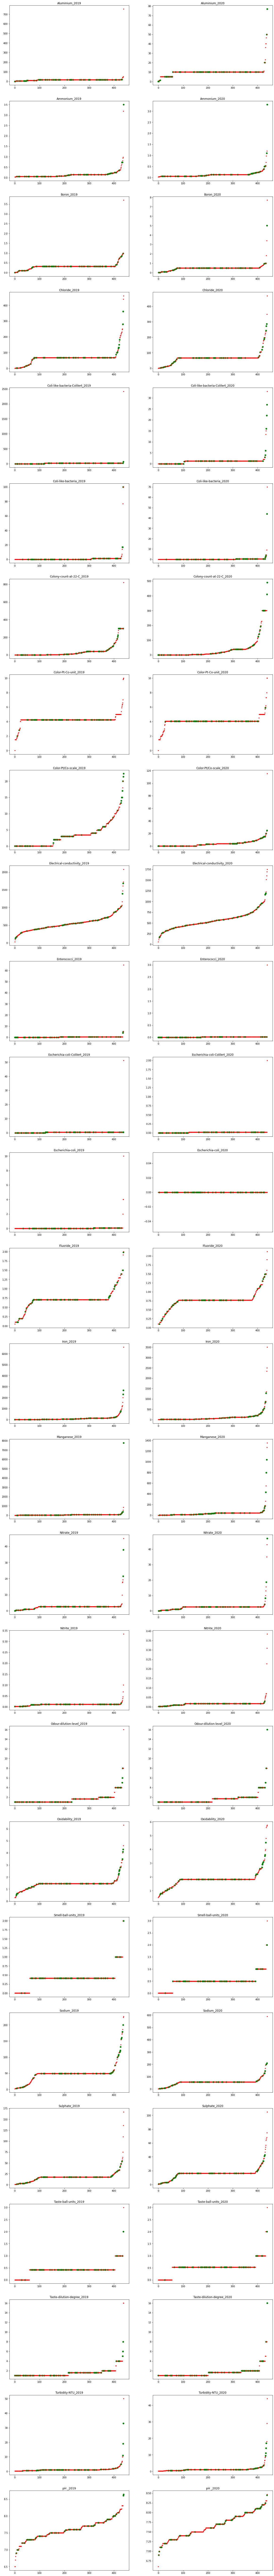

In [4]:
PlotFeatures(train_df, 27)

<font size=3>**TRAIN SETS**<font>

In [5]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=3>**PARIM RFC**<font> (runtime ~ 1 min) <br>
<font size=1>RFC(max_depth = 18, min_samples_split = 2, min_samples_leaf = 4) <br>
    acc = 84.5<font>

In [6]:
start = time()

all_params = []
all_acc = []

for leaf in range(1,10,3):
    for split in range(2,10,3):
        for depth in range(8,20):
            model = RFC(max_depth = depth, min_samples_split = split, min_samples_leaf = leaf)
            params = model.get_params()

            acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

            all_params.append(params)
            all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

63.53932762145996


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<font size=3>**TESTIMINE**<font>

In [7]:
test_df = pd.read_csv("test.csv").drop(columns=["compliance_2019", "compliance_2020"])
test_df = test_df.fillna(train_df.mean())
station_id = test_df["station_id"]
test_df = test_df.drop(columns="station_id")


model = RFC(max_depth = 15, min_samples_split = 2, min_samples_leaf = 4).fit(X_train, y_train)
results = model.predict(test_df)
results_df = pd.DataFrame({"station_id" : station_id, "compliance_2021" : results})
results_df.to_csv("RFC_1.csv", index = False)

<font size=6>**TEINE KATSE**<font>

<font size=3>**ANDMED**<font>

In [8]:
def data_cleaning(file):
    df = pd.read_csv(file).drop(columns=["compliance_2019", "compliance_2020", 
                                                      "Enterococci_2019", "Enterococci_2020", "Escherichia-coli-Colilert_2019",
                                                     "Escherichia-coli-Colilert_2020", "Escherichia-coli_2019", "Escherichia-coli_2020"])

    station_id = df["station_id"]
    df = df.drop(columns="station_id")

    cols = df.columns

    limit = [60, 1.5, 1.5, 300, 10, 30, 350, 8, 40, 3000, 1.75, 2000, 400, 20, 0.15, 10, 5, 3, 300, 80, 4, 10, 20, 9]

    for i in range(len(cols)-1):
        col = np.array(df[cols[i]].values.tolist())
        df[cols[i]] = np.where(col > limit[i//2], np.nan, col).tolist()

    df = df.fillna(df.mean())
    
    return [df, station_id]
    
train_df = data_cleaning("train.csv")[0]

<font size=3>**ANDMETE KUJUTUS**<font>

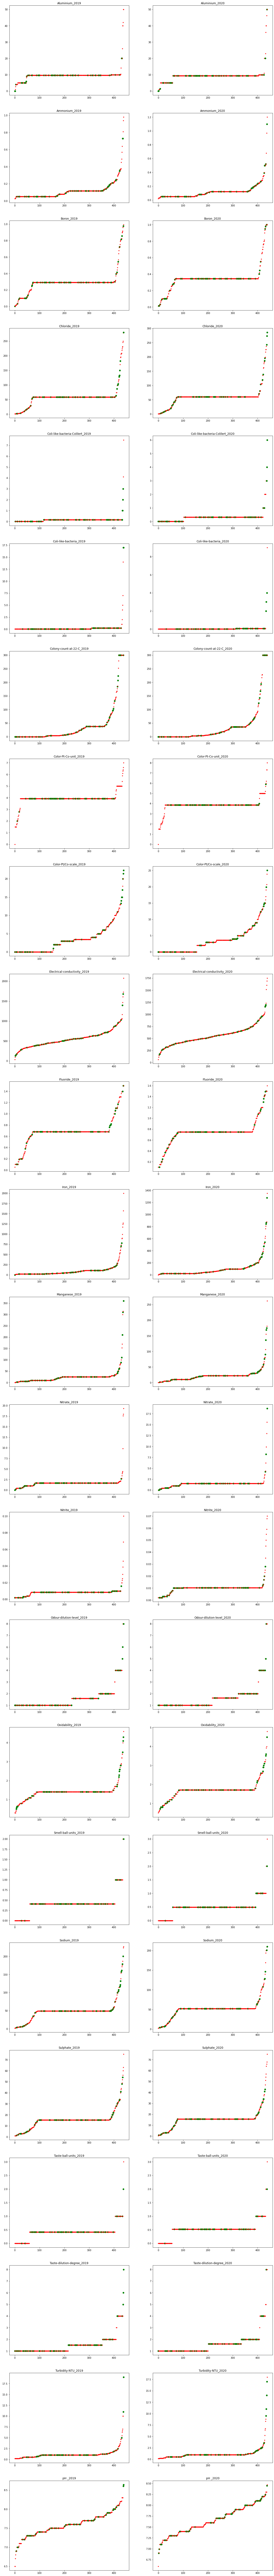

In [9]:
PlotFeatures(train_df, 24)

<font size=3>**TRAIN SETS**<font>

In [10]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=3>**TESTIMINE**<font>

In [11]:
test_df, station_id = data_cleaning("test.csv")

model = RFC(max_depth = 15, min_samples_split = 2, min_samples_leaf = 4).fit(X_train, y_train)
results = model.predict(test_df)
results_df = pd.DataFrame({"station_id" : station_id, "compliance_2021" : results})
results_df.to_csv("RFC_cleaned_data.csv", index = False)

<font size=6>**KOLMAS KATSE**<font>

<font size=3>**ANDMED**<font>

In [12]:
def data_cleaning_0(file):
    df = pd.read_csv(file).drop(columns=["compliance_2019", "compliance_2020", 
                                                      "Enterococci_2019", "Enterococci_2020", "Escherichia-coli-Colilert_2019",
                                                     "Escherichia-coli-Colilert_2020", "Escherichia-coli_2019", "Escherichia-coli_2020"])

    station_id = df["station_id"]
    df = df.drop(columns="station_id")

    cols = df.columns

    limit = [60, 1.5, 1.5, 300, 10, 30, 350, 8, 40, 3000, 1.75, 2000, 400, 20, 0.15, 10, 5, 3, 300, 80, 4, 10, 20, 9]

    for i in range(len(cols)-1):
        col = np.array(df[cols[i]].values.tolist())
        df[cols[i]] = np.where(col > limit[i//2], np.nan, col).tolist()

    df = df.fillna(0)
    
    return [df, station_id]
    
train_df = data_cleaning("train.csv")[0]

<font size=3>**TRAIN SETS**<font>

In [13]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=3>**TESTIMINE**<font>

In [14]:
test_df, station_id = data_cleaning_0("test.csv")

model = RFC(max_depth = 15, min_samples_split = 2, min_samples_leaf = 4).fit(X_train, y_train)
results = model.predict(test_df)
results_df = pd.DataFrame({"station_id" : station_id, "compliance_2021" : results})
results_df.to_csv("RFC_cleaned_data_0.csv", index = False)

<font size=6>**NELJAS KATSE**<font>

<font size=3>**ANDMED**<font>

In [15]:
train_df = data_cleaning("train.csv")[0]

<font size=3>**TRAIN SETS**<font>

In [16]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=3>**ERINEVAD MUDELID**<font>

<font size=2>**RFC**<font> (runtime ~ 6.2 h) <br>
<font size=1>RFC(criterion = "gini", n_estimators = 10, max_depth = 13, min_samples_split = 2, min_samples_leaf = 3) <br>
    acc = 85.9<font>

In [17]:
start = time()

all_params = []
all_acc = []

for leaf in range(1,10,2):
    for split in range(2,10,2):
        for depth in range(8,20):
            for crit in ["gini", "entropy"]:
                for n in range(10,401,10):
                    model = RFC(criterion = crit, n_estimators = n, max_depth = depth, min_samples_split = split, min_samples_leaf = leaf)
                    params = model.get_params()

                    acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

                    all_params.append(params)
                    all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

22350.931278705597
0.8590909090909091
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


<font size=2>**KNN**<font>  (runtime ~ 8 min)<br>
<font size=1>KNN(n_neighbors = 13, metric = "euclidean", leaf_size = 28) <br>
    acc = 85.2<font>

In [18]:
start = time()

all_params = []
all_acc = []

for leaf in range(10,101):
    for nr in range(1,20):
        for met in ["cityblock", "cosine", "euclidean"]:
            model = KNN(n_neighbors = nr, metric = met, leaf_size = leaf)
            params = model.get_params()
            
            acc = cross_val_score(model, X_train, y_train, cv = 5).mean()   
            
            all_params.append(params)
            all_acc.append(acc)
        
df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

484.70642828941345
0.8522727272727273
{'algorithm': 'auto', 'leaf_size': 28, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}


<font size=2>**DTC**<font> (runtime ~ 46 s)<br>
<font size=1>DTC(criterion = "gini", max_depth = 8, min_samples_split = 9, min_samples_leaf = 2) <br>
    acc = 82.1<font>

In [23]:
start = time()

all_params = []
all_acc = []

for crit in ["gini", "entropy"]:
    for leaf in range(1,10):
        for split in range(2,10):
            for depth in range(8,20):
                model = DTC(criterion = crit, max_depth = depth, min_samples_split = split, min_samples_leaf = leaf)
                params = model.get_params()
                
                acc = cross_val_score(model, X_train, y_train, cv = 5).mean()
                   
                all_params.append(params)
                all_acc.append(acc)

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

Time: 45.55 s

Acc: 82.05 %

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


<font size=2>**SVC (auto)**<font> (runtime ~ 1 min) <br>
<font size=1>acc = 73<font>

In [20]:
start = time()

model = SVC(kernel = "poly", gamma = "auto")
acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

print("Time: {} s\n".format(round(time()-start, 2)))
acc

66.93739748001099


array([0.76136364, 0.78409091, 0.68181818, 0.75      , 0.68181818])

<font size=2>**SVC (scale)**<font> (runtime ~ 1 s)<br>
<font size=1>acc = 84.7<font>

In [21]:
start = time()

model = SVC(kernel = "poly", gamma = "scale")
acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

print("Time: {} s\n".format(round(time()-start, 2)))
acc

0.04150581359863281


0.8477272727272727

<font size=6>**VIIES KATSE**<font>

<font size=3>**ANDMED**<font>

In [110]:
train_df = pd.read_csv("train.csv").drop(columns=["station_id", "compliance_2019", "compliance_2020"])

<font size=3>**ANDMETE KUJUTUS**<font>

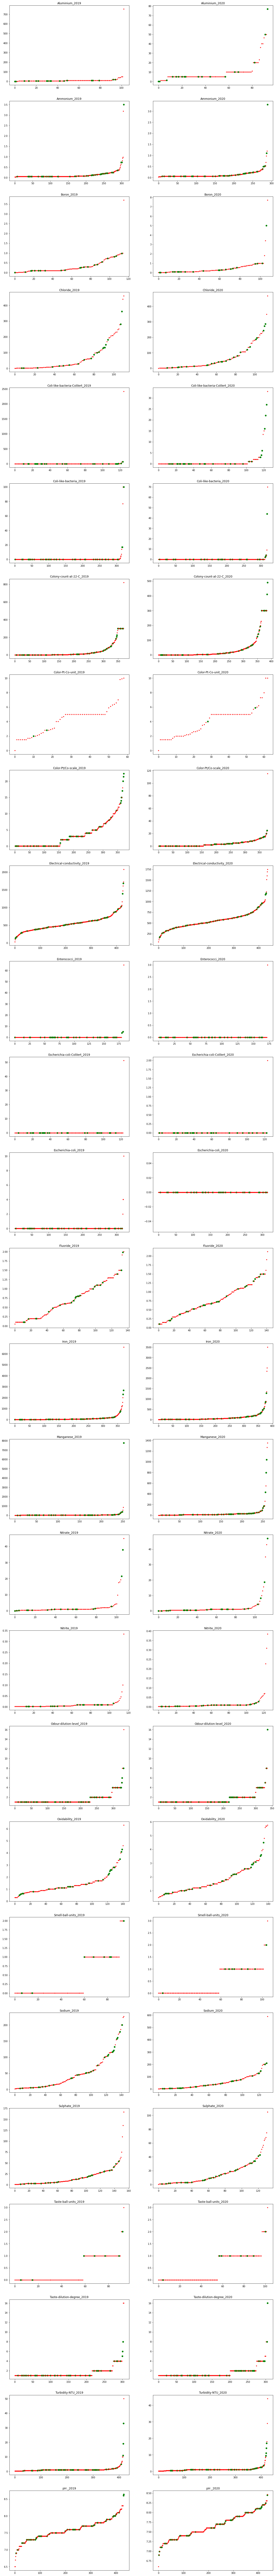

In [111]:
PlotFeatures(train_df, 27)

<font size=3>**TRAIN SETS**<font>

In [112]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=2>**HGBC**<font> (runtime ~ 48 s) <br>
<font size=1>HGBC(learning_rate = 0.01, max_iter = 100) <br>
    acc = 85<font>

In [113]:
start = time()

all_params = []
all_acc = []

for rate in [0.01, 0.05, 0.1]:
    for iteration in range(100, 500, 100):
        model = HGBC(learning_rate = rate, max_iter = iteration)
        params = model.get_params()

        acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

        all_params.append(params)
        all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

Time: 44.3 s

Acc: 85.0 %

{'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


<font size=2>**HGBC**<font> (runtime ~ 10 s) <br>
<font size=1>HGBC(learning_rate = 0.01, max_iter = 100, max_depth = 5) <br>
    acc = 85.2<font>

In [114]:
start = time()

all_params = []
all_acc = []

for depth in range(1,10):
    model = HGBC(learning_rate = 0.01, max_iter = 100, max_depth = depth)
    params = model.get_params()

    acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

    all_params.append(params)
    all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

Time: 9.42 s

Acc: 85.22999999999999 %

{'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 5, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


<font size=3>**TESTIMINE**<font>

In [115]:
test_df = pd.read_csv("test.csv").drop(columns=["compliance_2019", "compliance_2020"])
station_id = test_df["station_id"]
test_df = test_df.drop(columns="station_id")


model = HGBC(learning_rate = 0.01, max_iter = 100, max_depth = 5).fit(X_train, y_train)
results = model.predict(test_df)
results_df = pd.DataFrame({"station_id" : station_id, "compliance_2021" : results})
results_df.to_csv("HGBC_2.csv", index = False)

<font size=6>**KUUES KATSE**<font>

<font size=3>**ANDMED**<font>

In [116]:
def data_cleaning_nan_not_dropped(file):
    df = pd.read_csv(file).drop(columns=["compliance_2019", "compliance_2020", 
                                                      "Enterococci_2019", "Enterococci_2020", "Escherichia-coli-Colilert_2019",
                                                     "Escherichia-coli-Colilert_2020", "Escherichia-coli_2019", "Escherichia-coli_2020"])

    station_id = df["station_id"]
    df = df.drop(columns="station_id")

    cols = df.columns

    limit = [60, 1.5, 1.5, 300, 10, 30, 350, 8, 40, 3000, 1.75, 2000, 400, 20, 0.15, 10, 5, 3, 300, 80, 4, 10, 20, 9]

    for i in range(len(cols)-1):
        col = np.array(df[cols[i]].values.tolist())
        df[cols[i]] = np.where(col > limit[i//2], np.nan, col).tolist()
    
    return [df, station_id]
    
train_df = data_cleaning_nan_not_dropped("train.csv")[0]

<font size=3>**ANDMETE KUJUTUS**<font>

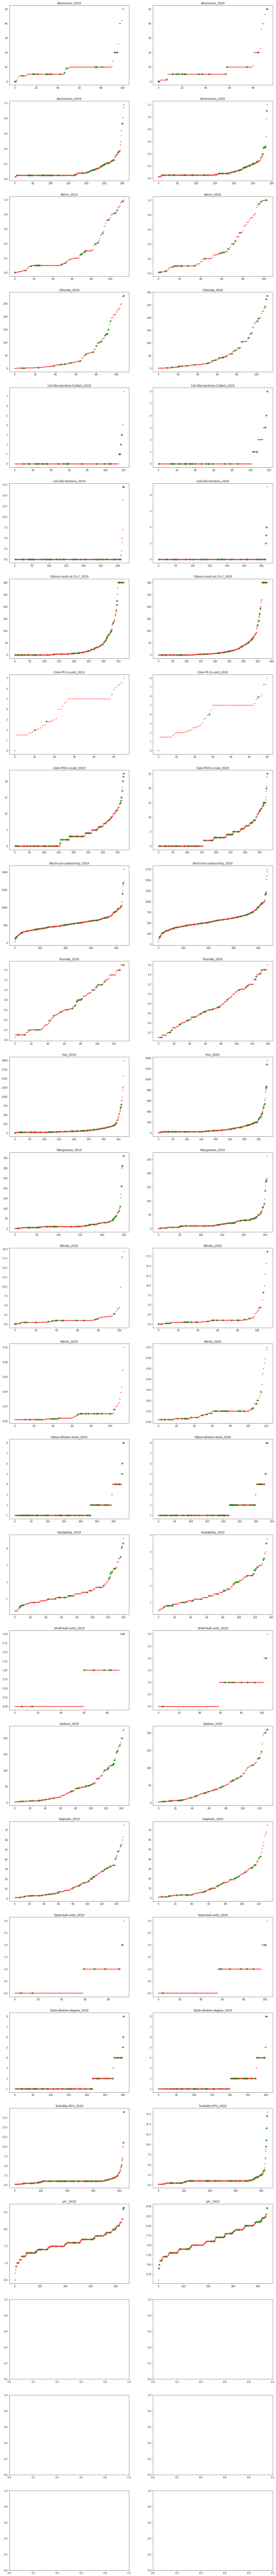

In [117]:
PlotFeatures(train_df, 27)

<font size=3>**TRAIN SETS**<font>

In [118]:
X_train = train_df.drop(columns="compliance_2021")
y_train = train_df["compliance_2021"]

<font size=2>**HGBC**<font> (runtime ~ 7 s) <br>
<font size=1>HGBC(learning_rate = 0.01) <br>
    acc = 85<font>

In [119]:
start = time()

all_params = []
all_acc = []

for rate in [0.01, 0.02, 0.03, 0.5, 0.1]:
    model = HGBC(learning_rate = rate)
    params = model.get_params()

    acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

    all_params.append(params)
    all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

Time: 7.21 s

Acc: 85.0 %

{'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


<font size=2>**HGBC**<font> (runtime ~ 32 s) <br>
<font size=1>HGBC(learning_rate = 0.01, min_samples_leaf = 9) <br>
    acc = 85.2<font>

In [120]:
start = time()

all_params = []
all_acc = []

for leaf in range(1,10):
    model = HGBC(learning_rate = 0.01, min_samples_leaf = leaf)
    params = model.get_params()

    acc = cross_val_score(model, X_train, y_train, cv = 5).mean()

    all_params.append(params)
    all_acc.append(acc)
                

df_results = pd.DataFrame({"params" : all_params, "acc" : all_acc}).sort_values(by="acc", ascending=False)

print("Time: {} s\n".format(round(time()-start, 2)))
print("Acc: {} %\n".format(round(df_results.iloc[0].acc, 4)*100))
print(df_results.iloc[0].params)

Time: 32.08 s

Acc: 85.22999999999999 %

{'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 9, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


<font size=3>**TESTIMINE**<font>

In [108]:
test_df, station_id = data_cleaning_nan_not_dropped("test.csv")

model = HGBC(learning_rate = 0.01, min_samples_leaf = 9).fit(X_train, y_train)
results = model.predict(test_df)
results_df = pd.DataFrame({"station_id" : station_id, "compliance_2021" : results})
results_df.to_csv("HGBC_data_cleaning_nan_not_dropped.csv", index = False)